In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


stemmer = WordNetLemmatizer()
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
train = pd.read_csv('Devex_train.csv', engine='python')
test = pd.read_csv('Devex_test_questions.csv', engine="python") 


display(train.head(3))
display(test.head(3))

,Unique ID,Type,Text,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7,Label 8,Label 9,Label 10,Label 11,Label 12
0,12555,Grant,Centers of Biomedical Research Excellence (COB...,3.b.2 - Total net official development assista...,3.c.1 - Health worker density and distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14108,Grant,Research on Regenerative Medicine <h2><strong>...,3.b.2 - Total net official development assista...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23168,Organization,Catholic Health Association of India (CHAI): <...,3.d.1 - International Health Regulations (IHR)...,3.8.1 - Coverage of essential health services ...,3.8.2 - Proportion of population with large ho...,3.b.3 - Proportion of health facilities that h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Unique ID,Type,Text
0,49848,Organization,4th Sector Health: <p>4th Sector Health is a U...
1,52348,Organization,Action for Global Health: <p>Action for Global...
2,103541,Organization,Scottish Association for Mental Health (SAMH):...


### Text Cleaning With re module

In [3]:
def clean_text(text):
#    for text in text:
    text = re.sub('<.*?>', ' ', text)                   #remove any html tags
    text = re.sub('&nbsp;', ' ', text)                 #improper html decoding
    text = re.sub('&bull;', ' ', text)                  #improper html decoding
    text = re.sub(r'\W', ' ', str(text))                ## remove special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', str(text))    #remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ',  text)         #remove single characters from the from
    text = re.sub(r'\s+', ' ', text, flags= re.I)       #substitute mutiple spaces with a single space
    text = re.sub(r'^b\s+', '', text)                   #Remove prefixed 'b'
    text = text.lower()                                 #change to lower caps
    text = text.split()
    text = [stemmer.lemmatize(word) for word in text]   #lemmatize
    text = " ".join(text)
    #documents.append(text)
    return text


#Apply the function to clean the text
train['Text'] = train['Text'].apply(clean_text)

### Extract the SDG Codes

In [4]:
target_labels = pd.read_csv("Devex_submission_format.csv").columns.tolist()[1:]
tags = []

def get_labels(data, target_labels):
    new_dict = {}                                                                   #initiate empty dictionary
    for row in range(0, data.shape[0]):                                             #all rows of dataframe
        combined =[]                                                                #initiate the row list
        for i in range(1, 13):
            label = data.loc[row, 'Label {}'.format(i)]                             #indexing to get the value
            try:
                tag = re.search(r'(?P<tag>.*)(:?\s-)', label).group('tag').strip()  #get tag using re
                combined.append(tag)                                                #append to row list of tags
            except:
                pass                                                                #no tag do nothing
        for target in target_labels:                                                #iterate through the labels
            if target in combined:                                                  #check if label is in row list
                new_dict.setdefault(target, []).append(1)                           #if exists append 1 to label
            else:
                new_dict.setdefault(target, []).append(0)                           #else a zero

    return new_dict                                                                 #return dictionary

#check results

clean_label = get_labels(train, target_labels)
clean_label.keys()

dict_keys(['3.1.1', '3.1.2', '3.2.1', '3.2.2', '3.3.1', '3.3.2', '3.3.3', '3.3.4', '3.3.5', '3.4.1', '3.4.2', '3.5.1', '3.5.2', '3.6.1', '3.7.1', '3.7.2', '3.8.1', '3.8.2', '3.9.1', '3.9.2', '3.9.3', '3.a.1', '3.b.1', '3.b.2', '3.b.3', '3.c.1', '3.d.1'])

### Create a New DataFrame From the Dictionary 

In [5]:
df = pd.DataFrame(clean_label)

In [6]:
def get_label(x):
    try:
        tag = re.search(r'(?P<tag>.*?)(:?\s-)', x).group('tag')
        return tag
    except:
        return 0
    
# labels = ['Label {}'.format(i) for i in range(1, 13)]
# train[labels] = train[labels].applymap(get_label)

# train[labels].head()

### Reorder the Columns

In [7]:
df.insert(0, 'Type', train.loc[:, 'Type'])
df.insert(1, 'Text', train.loc[:, 'Text'])

# df = pd.get_dummies(df, columns=['Type'], prefix="type", drop_first=True)
# df.head(3)

### Exploratory Data Analysis

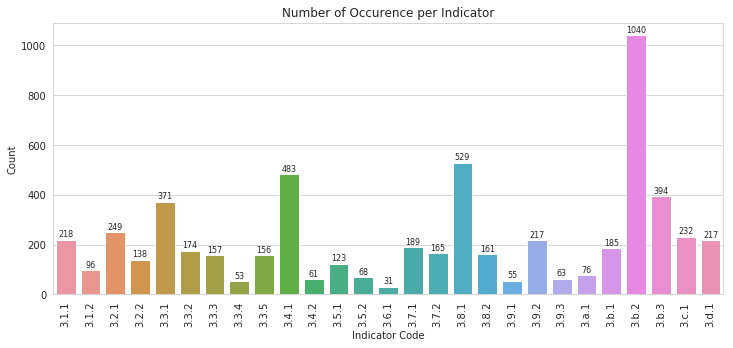

In [8]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(df.iloc[:, 2:].sum().index, df.iloc[:, 2:].sum().values)
plt.title("Number of Occurence per Indicator")
plt.xlabel("Indicator Code")
plt.ylabel("Count")
plt.xticks(rotation = 90)
rects = ax.patches
labels = df.iloc[:, 2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=8)
plt.show()

- SDG Indicators **Total net official development assistance code (3.b.2)** apperaed the most frequent.
- 3.6.1 occured the least frequent.

#### Text with Multiple Indicators

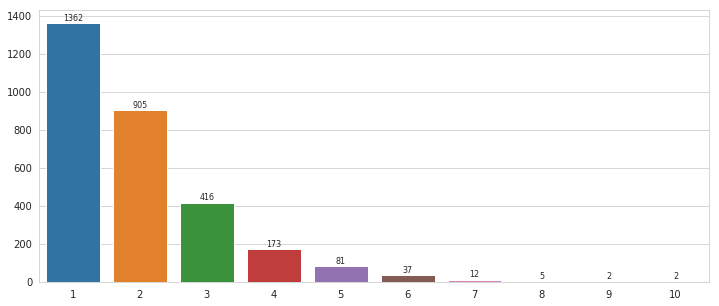

In [9]:
sum_rows = df.iloc[:, 2:].sum(axis = 1)
label_counts= sum_rows.value_counts()

lc_index = label_counts.index
lc_values = label_counts.values

plt.figure(figsize=(12, 5))
ax = sns.barplot(lc_index, lc_values)
bars = ax.patches

for bar, val in zip(bars, lc_values):
    height = bar.get_height()
    width = bar.get_width()
    xtick_loc = bar.get_x()
    ax.text(x = xtick_loc + width /2, y = height + 5, s = val, ha='center', va='bottom', fontsize=8)
    
plt.show()

- Most of the text have 3 or less relevant indicators.
- With only 2 having 9 or 10 indicators and none having more than 10.

#### Most Frequent Words 

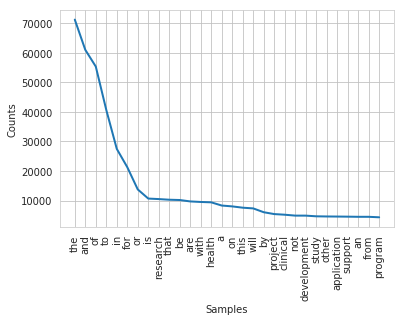

In [10]:
from nltk.tokenize import word_tokenize

joined_text = df['Text'].str.cat(sep = ',')
tokens = word_tokenize(joined_text, language = 'english')
freq = nltk.FreqDist(tokens)
freq.plot(30, cumulative = False)

- From the above we notice alot of the conjusctions dorminating the plot and they tend not to be very informative

#### Remove Stopwords and Plot again

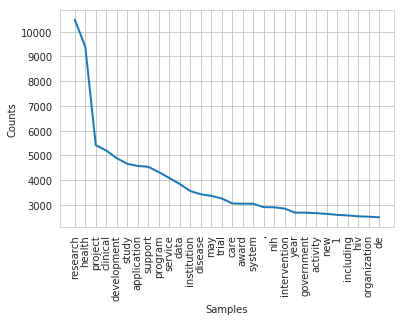

In [11]:
clean_tokens = [word for word in tokens if word not in stopwords.words('english')]
freq2 = nltk.FreqDist(clean_tokens)
freq2.plot(30, cumulative=False)

- Much better now we see research seems to be the most mentioned on the text, followed by health
- HIV and intervention are also mentioned clearly re-inforcing the premonence of health topic

#### Generate a Word cloud

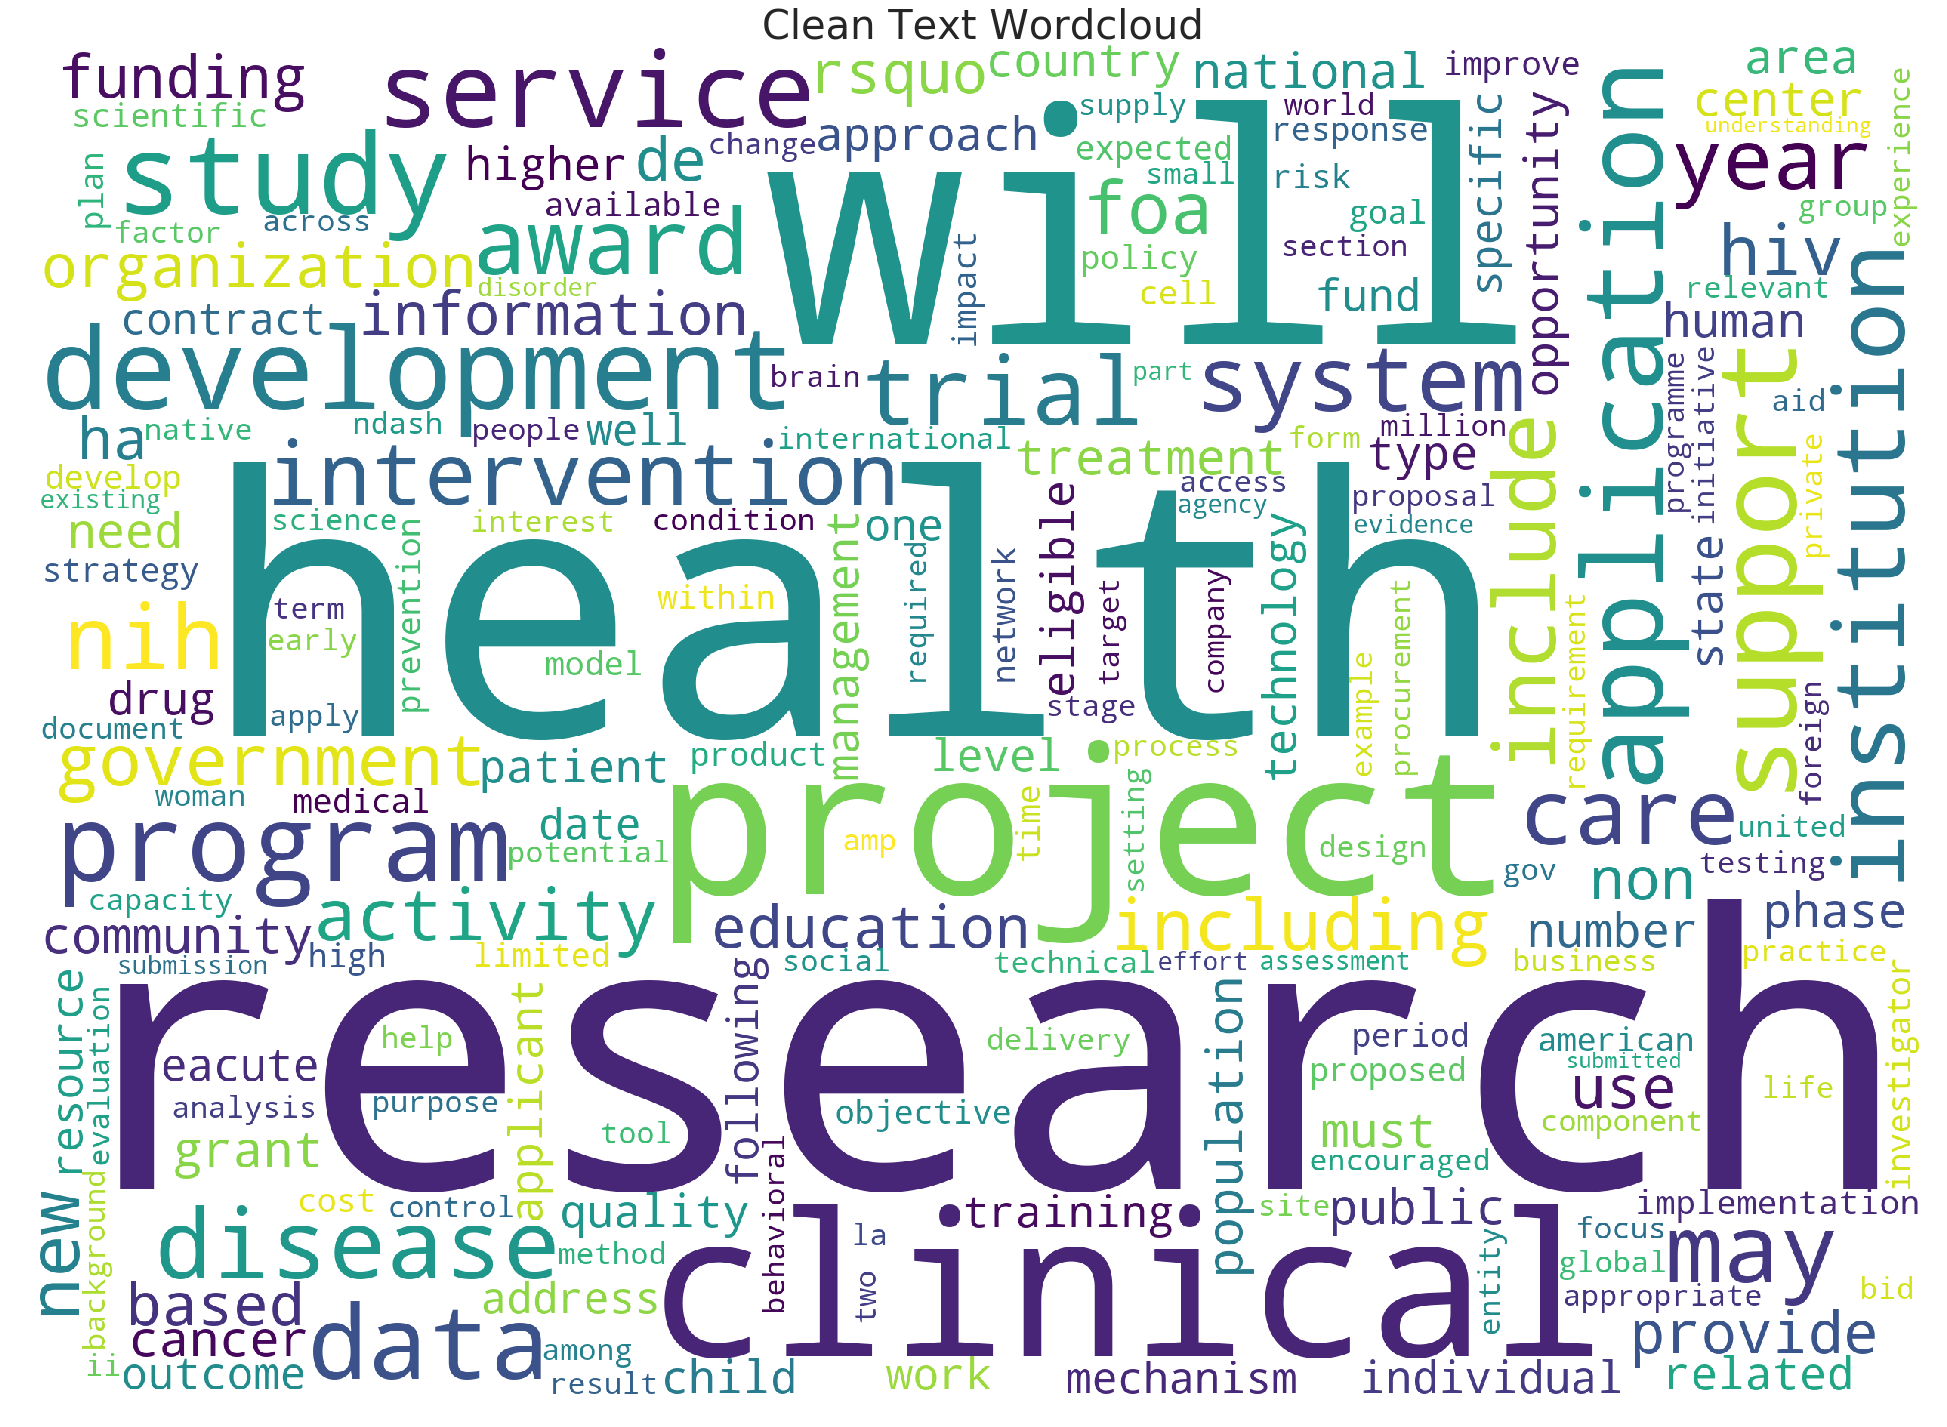

In [12]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

wd = WordCloud(
              stopwords=STOPWORDS,
              background_color='white',
              collocations=False,
              width=2500,
              height=1800
             ).generate(joined_text)
plt.axis('off')
plt.title("Clean Text Wordcloud",fontsize=40)
plt.imshow(wd)

- The word cloud brings quite a lot into perspective.
- We see research quite prominent with clinical and health and developemtn. Probably indicating research and development in the health sector.
- Data and study are also visible showing the stress on the need/use of data and research studies.

### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score

X = df['Text']
y_labels = [i for i in df.columns.tolist() if i.startswith('3.')]
y = df[y_labels].values

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Finding Bag of Words

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer(max_features= 1000, ngram_range=(1, 2), 
                     min_df=5, max_df=0.8, stop_words= stopwords.words('english'))

X_train_array = cv.fit_transform(X_train).toarray()
X_test_array = cv.transform(X_test).toarray()

X_train_array.shape , X_test_array.shape

((2096, 1000), (899, 1000))

### Finding TfIdf

In [15]:
tfidf = TfidfTransformer()
Xtrain_tfidf = tfidf.fit_transform(X_train_array).toarray()
Xtest_tfidf = tfidf.transform(X_test_array).toarray()

Xtrain_tfidf.shape, Xtest_tfidf.shape

((2096, 1000), (899, 1000))

### Combine the Type dummy variables to the data

In [16]:
# types = [i for i in df.columns if i.startswith('type_')]
# types_array = df[types].values
# types_array.shape

# X_tfidf = np.append(X_tfidf, types_array, axis = 1)

### Make Predictions using MultiOutPutClassifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn import metrics


#define the classifier
forest = RandomForestClassifier(n_estimators = 100, random_state = 0)

#Use Multioutput
classifier = MultiOutputClassifier(forest, n_jobs=-1)

#Fit the model
classifier.fit(Xtrain_tfidf, y_train)

#make predictions
y_pred = classifier.predict(Xtest_tfidf)

acc = metrics.accuracy_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)


print("Accuracy :", acc)

Accuracy : 0.271412680756396


#### Predictions Using Binary Relevance

In [18]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
classifier = BinaryRelevance(RandomForestClassifier(n_estimators = 100, random_state = 0))

# fit the model
classifier.fit(Xtrain_tfidf, y_train)

# make predictions
y_pred = classifier.predict(Xtest_tfidf)

#check accuracy
print("Accuracy :",metrics.accuracy_score(y_test, y_pred))

Accuracy : 0.271412680756396


#### Predictions Using Classifier Chains

In [19]:

from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
# initialize classifier chains multi-label classifier
#classifier = ClassifierChain(LogisticRegression())
classifier = ClassifierChain(RandomForestClassifier(n_estimators = 100, random_state = 0))

# Fit the model
classifier.fit(Xtrain_tfidf, y_train)

#make predictions predict
y_pred = classifier.predict(Xtest_tfidf)

#check accuracy
print("Accuracy :",metrics.accuracy_score(y_test, y_pred))


Accuracy : 0.2925472747497219


#### Predictions Using Label Powerset

In [20]:
from skmultilearn.problem_transform import LabelPowerset
# initialize label powerset multi-label classifier

#classifier = LabelPowerset(LogisticRegression())
classifier = LabelPowerset(RandomForestClassifier(n_estimators = 100, random_state = 0))

#fit the model
classifier.fit(Xtrain_tfidf, y_train)

#make predictions
y_pred = classifier.predict(Xtest_tfidf)

print("Accuracy :",metrics.accuracy_score(y_test, y_pred))


Accuracy : 0.32146829810901


### Make Predictions`

In [26]:
test = pd.read_csv('Devex_test_questions.csv', engine="python")

test['Text'] = test['Text'].apply(clean_text)
cv = CountVectorizer(max_features= 1000, ngram_range=(1, 2), 
                     min_df=5, max_df=0.8, stop_words= stopwords.words('english'))

X_train = cv.fit_transform(X).toarray()
tfidf = TfidfTransformer()
Xtrain_tfidf = tfidf.fit_transform(X_train).toarray()

test_X = test['Text']
test_array = cv.transform(test_X).toarray()
test_tfidf = tfidf.transform(test_array).toarray()


forest = RandomForestClassifier(n_estimators = 500, max_depth = 1000, random_state = 0)
classifier = MultiOutputClassifier(forest, n_jobs=-1)

#Fit the model
classifier.fit(Xtrain_tfidf, y)
test_pred = classifier.predict(test_tfidf)


#### Create a DataFrame ommf Predictions and a Submission File

In [ ]:
submission = pd.DataFrame(test_pred, columns=[df.columns[2:]])

submission.insert(0, "ID", test['Unique ID'])

submission.head()

In [ ]:
### Make a submission file

In [ ]:
submission.to_csv("Submission sdg.csv", index = None)

# Acknowledgement
- [Deep Dive into multilabel classification - Towards Data Science]("https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff")
- 